In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\lax-josegal\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


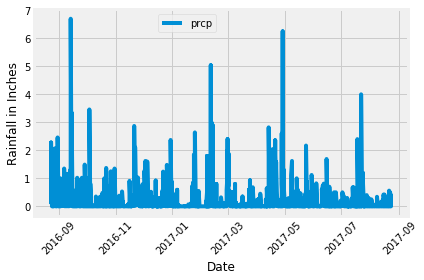

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
weatherDate = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for date in weatherDate:
    recentDate = date.date
    
recentDate = dt.datetime.strptime(recentDate, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
last12Months = recentDate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recentPrec = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last12Months).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(recentPrec).dropna()

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'])
plt.ylabel('Rainfall in Inches')
plt.legend(bbox_to_anchor=(0.5, 1.00))

plt.xticks(rotation='45')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStations = (session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all())

activeStations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stationId = activeStations[0][0]
stationName = (session.query(Station.name).filter_by(station = stationId))

# Lowest Temp
lowestTemp = (session.query(Measurement.tobs)\
                     .filter(Measurement.station == stationId)\
                     .order_by(Measurement.tobs.asc())\
                     .first())

# Highest Temp
highestTemp = (session.query(Measurement.tobs)\
                     .filter(Measurement.station == stationId)\
                     .order_by(Measurement.tobs.desc())\
                     .first())

# Calculate the average temperature 
avgTemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stationId))

print(f"Most Active Station: {stationName[0][0]}")
print(f"Lowest Temp: {lowestTemp[0]}")
print(f"Highest Temp: {highestTemp[0]}")
print(f"Average Temp: {avgTemp[0][0]}")


Most Active Station: WAIHEE 837.5, HI US
Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


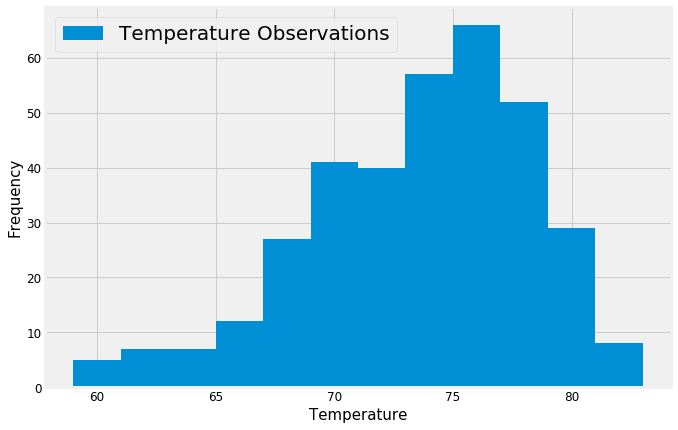

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = (session.query(Measurement.date, Measurement.tobs)\
                   .filter(Measurement.date > last12Months)\
                   .filter(Measurement.station == stationId)\
                   .order_by(Measurement.tobs.asc())\
                   .all())
# Convert to dataframe to use "bins" function
tempDf = pd.DataFrame(tempData)

# Rename the "tobs" column and drop NaN values
tempDf.rename(columns = {"tobs":"Temperature Observations"}, inplace = True)
tempDf = tempDf.dropna(axis=0, how="any")

# Plot the results as a histogram
tempDf.plot(kind="hist", bins=12, figsize=(10,7))
plt.xlabel("Temperature", size = 15)
plt.ylabel("Frequency", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend(prop={'size':20})
plt.savefig("Images/Temperature.png")

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calcTemps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calcTemps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calcTemps('2017-01-01', '2017-01-10')
temps

[(60.0, 68.0327868852459, 77.0)]

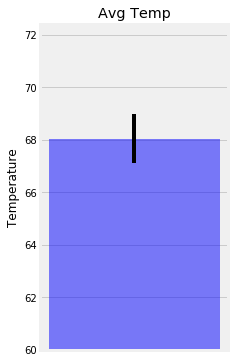

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='blue', alpha=0.5)
plt.title('Avg Temp')
plt.xticks([])
plt.ylabel('Temperature')
plt.ylim(60)

plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, 
                        Station.latitude, Station.longitude,
                        Station.elevation, func.sum(Measurement.prcp)).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= last12Months).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp)).all()

rainfall

[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.19),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  37.99),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.36000000000003),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  68.24000000000002),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.11000000000004)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
